## Downstream Task: ImageWang

[ImageWang](https://github.com/fastai/imagenette/blob/master/README.md) has a validation set that contains ten different dog breed types.

Let's try using this classification task as our downstream task.

In [2]:
import torch

from functools import partial
from torch.nn import CrossEntropyLoss
from torchvision.models import resnet34

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from pathlib import Path

from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.basics import DataBlock, RandomSplitter
from fastai2.learner import Learner
from fastai2.torch_core import num_distrib
from fastai2.callback.schedule import fit_flat_cos

from fastai2.data.block import CategoryBlock
from fastai2.data.transforms import (GrandparentSplitter, get_image_files,
                                     parent_label, Normalize, RegexLabeller, 
                                     parent_label)
from fastai2.data.external import URLs, untar_data

from fastai2.layers import MishJit, MaxPool, LabelSmoothingCrossEntropy

from fastai2.vision.data import ImageDataBunch
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform, FlipItem
from fastai2.vision.learner import cnn_learner, cnn_config, model_meta, _default_meta
from fastai2.vision.all import ImageBlock, get_image_files, imagenet_stats

from fastcore.utils import num_cpus

## Random Weights Baseline

Let's train a completely random network in the best way we know how. We will use all the tips and tricks from [training Imagenette](https://github.com/fastai/imagenette/tree/58a63175a2c6457650289d32741940d6a7d58fbf).

This approach is taken from: [train_imagenette.py](https://github.com/fastai/fastai2/blob/3faec089e511ee68330dfdc182add8c863df3ecd/nbs/examples/train_imagenette.py)

As of January 2020 the [best parameters](https://github.com/fastai/imagenette/blob/58a63175a2c6457650289d32741940d6a7d58fbf/2020-01-train.md) are:

```
--lr 8e-3 
--sqrmom 0.99 
--mom 0.95 
--eps 1e-6 
--bs 64 
--opt ranger 
--sa 1
--fp16 1 
--arch xse_resnext50 
--pool MaxPool
```

In [10]:
# Default parameters
gpu=None
lr=1e-2
size=128
sqrmom=0.99
mom=0.9
eps=1e-6
epochs=15
bs=64
mixup=0.
opt='ranger',
arch='xresnet50'
sh=0.
sa=0
sym=0
beta=0.
act_fn='MishJit'
fp16=0
pool='AvgPool',
dump=0
runs=1
meta=''

In [11]:
#TODO: Use xse-resnext50
from fastai2.vision.models.xresnet import xresnet50

# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
eps=1e-6
bs=64 
opt='ranger'
sa=1
fp16=0               #NOTE: My GPU cannot run fp16 :'(
arch='xse_resnext50' 
pool='MaxPool'

gpu=0

# NOTE: Normally loaded from their corresponding string
m = xresnet50
act_fn = MishJit
pool = MaxPool

runs = 3

In [12]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label)
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    return dblock.databunch(source, path=source, bs=bs, num_workers=workers,
                            item_tfms=item_tfms, batch_tfms=batch_tfms)

In [13]:
if gpu is not None: torch.cuda.set_device(gpu)
if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [14]:
size = 128
bs = 64

dbunch = get_dbunch(size, bs, sh=sh)
if not gpu: print(f'lr: {lr}; size: {size}; sqrmom: {sqrmom}; mom: {mom}; eps: {eps}')

lr: 0.008; size: 128; sqrmom: 0.99; mom: 0.95; eps: 1e-06


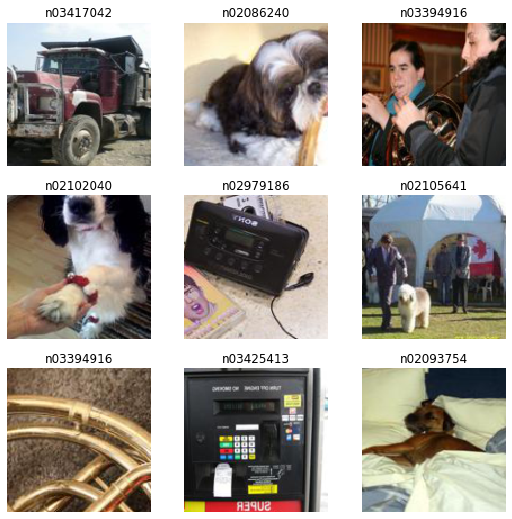

In [15]:
dbunch.show_batch()

In [16]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, m(c_out=20, act_cls=act_fn, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.735219,3.190908,0.071010,0.566302,00:40
1,1.497271,2.695905,0.166964,0.720540,00:41
2,1.381391,2.868918,0.163146,0.585391,00:40
3,1.328764,2.899149,0.169000,0.581573,00:41
4,1.250691,2.845134,0.179944,0.626114,00:41
5,1.189468,2.325685,0.345635,0.816238,00:42
6,1.165311,2.622849,0.276661,0.715449,00:40
7,1.102790,2.395009,0.329600,0.783660,00:40
8,1.089661,2.324015,0.360906,0.806567,00:40
9,1.072296,2.764524,0.247900,0.649275,00:40


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.727988,3.435446,0.021125,0.321456,00:39
1,1.492558,3.043511,0.100280,0.567829,00:39
2,1.419303,3.382724,0.039196,0.462968,00:39
3,1.299447,2.786009,0.212013,0.736829,00:39
4,1.258535,2.651549,0.238483,0.717231,00:40
5,1.207517,2.367809,0.302622,0.794859,00:40
6,1.162135,2.468568,0.296513,0.760753,00:40
7,1.123431,2.283959,0.376177,0.810130,00:41
8,1.091104,2.171500,0.401629,0.817256,00:41
9,1.060870,2.173132,0.414609,0.850344,00:40


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.730775,3.329659,0.040977,0.448969,00:38
1,1.507612,3.319779,0.074828,0.466276,00:38
2,1.389740,2.876729,0.138458,0.593535,00:38
3,1.305738,3.246064,0.136421,0.528633,00:39
4,1.240305,2.613768,0.257572,0.719267,00:38
5,1.202407,2.535437,0.269280,0.736320,00:38
6,1.164537,2.343450,0.339527,0.798167,00:38
7,1.127971,2.290198,0.374396,0.797149,00:39
8,1.089969,2.214817,0.395775,0.807839,00:38
9,1.064400,2.484065,0.308221,0.700687,00:38


## Run with pretext weights

For this experiment we run using the weights generated by pretraining our network on a pretext task. We're hoping that by pretraining a neural network on a pretext task, we get weights that are in a better position to learn this downstream classification task (as compared to random weights).

In [129]:
loss = CrossEntropyLoss()
learn = cnn_learner(databunch, resnet34, pretrained=False, config=cnn_config(), loss_func=loss, metrics=[accuracy])

In [130]:
# Load backbone from saved model
# NOTE: This step depends on running all cells from 02_ImagePatches_ImageWang.ipynb
state_dict = torch.load('pascal_15_epoch.pth')
learn.model[0].load_state_dict(state_dict)
learn.freeze()

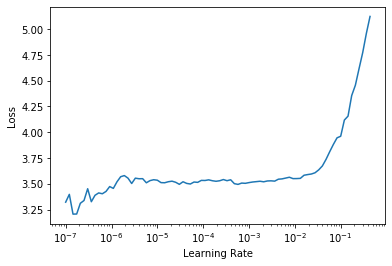

In [131]:
learn.lr_find()

In [132]:
learn.fit_one_cycle(5, slice(10e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.287449,3.253466,0.127389,00:16
1,2.958001,2.730592,0.122293,00:17
2,2.658242,2.361057,0.157962,00:17
3,2.427255,2.287079,0.193631,00:17
4,2.309800,2.173093,0.205096,00:17


In [ ]:
learn.unfreeze()
learn.lr_find()

In [133]:
learn.fit_one_cycle(10, slice(10e-4, 10e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.301041,2.101185,0.214013,00:22
1,2.411435,2.360674,0.169427,00:23
2,2.255489,2.326856,0.157962,00:23
3,2.150144,2.276299,0.194904,00:22
4,2.080085,1.993220,0.247134,00:22
5,1.986100,1.930611,0.280255,00:22
6,1.874988,1.774678,0.343949,00:22
7,1.806772,1.688903,0.360510,00:22
8,1.723014,1.649664,0.379618,00:22
9,1.678803,1.635251,0.392357,00:22


## Run with ImageNet Weights

For this experiment we run using the weights generated by pretraining our network on ImageNet. 

In [137]:
loss = CrossEntropyLoss()
learn = cnn_learner(databunch, resnet34, pretrained=True, config=cnn_config(), loss_func=loss, metrics=[accuracy])

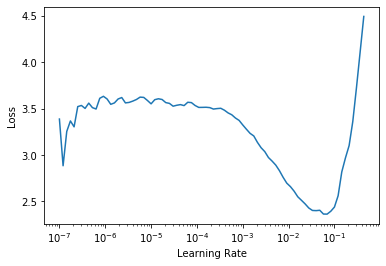

In [138]:
learn.lr_find()

In [139]:
# Fine tune on this task
learn.fit_one_cycle(5, lr_max=10e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.331456,10.617470,0.101911,00:15
1,4.771839,4.759386,0.145223,00:16
2,3.069615,2.822441,0.189809,00:17
3,2.380256,2.215498,0.217834,00:17
4,2.056978,1.948544,0.319745,00:17


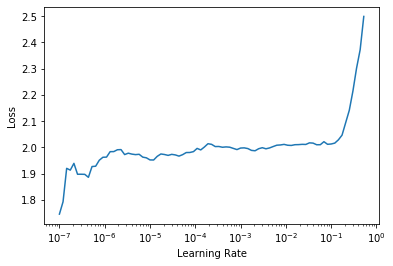

In [140]:
learn.lr_find()

In [141]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(10e-4, 10e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.096447,87.447083,0.121019,00:22
1,2.190989,2.600005,0.165605,00:22
2,2.115496,4.348145,0.229299,00:22
3,2.073757,15.071845,0.235669,00:22
4,2.014063,14.357773,0.298089,00:23
5,1.892217,4.347929,0.301911,00:23
6,1.841710,1.934102,0.323567,00:23
7,1.765970,1.973020,0.393631,00:23
8,1.689572,1.604584,0.428025,00:23
9,1.669283,1.594876,0.438217,00:23


So it looks like we get

- ~25% accuracy when using random weights
- ~39% accuracy when using pretext weights
- ~44% accuracy when using ImageNet weights